# Introduction 

DeepMAC (Deep Mask-heads Above CenterNet) is model to tackle the problem of partially supervised instance segmentation in which we are given box annotations for all classes, but masks for only a subset of classes.

@vighneshbgoogle and @sbeery shared [Run DeepMAC inference for iWildCam](https://www.kaggle.com/vighneshbgoogle/run-deepmac-inference-for-iwildcam) notebook, and I got interested in DeepMAC model.

To see how well DeepMAC can create instance masks, I tried it for data of [iWildcam 2021 - FGVC8](https://www.kaggle.com/c/iwildcam2021-fgvc8), [Global Wheat Detection](https://www.kaggle.com/c/global-wheat-detection) and [HuBMAP - Hacking the Kidney](https://www.kaggle.com/c/hubmap-kidney-segmentation) in Example1 ~ 3. I also show how we can use the model for more realistic applications in Application1 and 2.

I have used most of the code of original notebook, especially for chapters 1 and 2 (see Contents list below). After chapter3, my code is main.

## Contents

0. [About DeepMAC](#0)
1. [Preparation](#1)
2. [Examle1 iWildcam 2021 - FGVC8](#2)
3. [Examle2 Global Wheat Detection](#3)
4. [Examle3 HuBMAP - Hacking the Kidney](#4)
5. [Application1 Create instance mask of iWildcam 2021 for MOT](#5)
5. [Application2 Create instance mask of HuBMAP in a way that can be automated as much as possible.](#6)


### Reference for DeepMAC

* github.io: [The surprising impact of mask-head architecture
on novel class segmentation](https://google.github.io/deepmac/).

* Paper: [The surprising impact of mask-head architecture on novel class segmentation](https://arxiv.org/abs/2104.00613)

* Sample code: [DeepMAC colab](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/deepmac_colab.ipynb) in the Object Detection API

-----------------------

<a id="0"></a>
# About DeepMAC

The idea of DeepMAC is based on [MASK R-CNN](https://arxiv.org/abs/1703.06870). DeepMAC has shown significant performance improvement in creating instance masks of unknown objects. There are some differences between previous study like following:

* Deeper and hourglass network as mask-heads.

* Train late stage networks using not proposals of RPN but ground truth.

To learn about DeepMAC, it seems be efficient to learn along the way how they have developed. I'll list the papers in the order below, but I think it's pretty easy to study up to Mask R-CNN, since there are already many explanatory articles on the Internet and notebooks on kaggle. 

1. R-CNN: [Rich feature hierarchies for accurate object detection and semantic segmentation](https://arxiv.org/pdf/1311.2524.pdf)

2. [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/abs/1506.01497)

3. [Mask R-CNN](https://arxiv.org/abs/1703.06870)

4. DeepMAC: [The surprising impact of mask-head architecture on novel class segmentation](https://arxiv.org/abs/1703.06870)

<a id="1"></a>
# Preparation
## Imports and Definitions

Load libraries to use and define utility functions.

In [1]:
# Load libraries

import collections
from collections import defaultdict
import glob
import gc
import io
import json
import logging
import os
import random
import warnings

import imageio
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import matplotlib
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import scipy.misc
from six import BytesIO
from skimage import color
from skimage import measure
from skimage import transform
from skimage import util
from skimage.color import rgb_colors
import tensorflow as tf
import tifffile as tiff 

In [2]:
# For checking GPU setting

print('tensorflow version:', tf.__version__)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu_device in gpu_devices:
        print('device available:', gpu_device)

tensorflow version: 2.4.1


In [3]:
# Define utilities

COLORS = ([rgb_colors.cyan, rgb_colors.orange, rgb_colors.pink,
           rgb_colors.purple, rgb_colors.limegreen , rgb_colors.crimson] +
          [(color) for (name, color) in color.color_dict.items()])
random.shuffle(COLORS)

logging.disable(logging.WARNING)


def read_image(path):
  """Read an image and optionally resize it for better plotting."""
  with open(path, 'rb') as f:
    img = Image.open(f)
    return np.array(img, dtype=np.uint8)

def read_json(path):
  with open(path) as f:
    return json.load(f)

def create_detection_map(annotations):
  """Creates a dict mapping IDs to detections."""

  ann_map = {}
  for image in annotations['images']:
    ann_map[image['id']] = image['detections']
  return ann_map

def get_mask_prediction_function(model):
  """Get single image mask prediction function using a model."""

  @tf.function
  def predict_masks(image, boxes):
    height, width, _ = image.shape.as_list()
    batch = image[tf.newaxis]
    boxes = boxes[tf.newaxis]

    detections = model(batch, boxes)
    masks = detections['detection_masks']

    return reframe_box_masks_to_image_masks(masks[0], boxes[0],
                                             height, width)

  return predict_masks

def convert_boxes(boxes):
  xmin, ymin, width, height = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
  ymax = ymin + height
  xmax = xmin + width

  return np.stack([ymin, xmin, ymax, xmax], axis=1).astype(np.float32)


# Copied from tensorflow/models
def reframe_box_masks_to_image_masks(box_masks, boxes, image_height,
                                     image_width, resize_method='bilinear'):
  """Transforms the box masks back to full image masks.
  Embeds masks in bounding boxes of larger masks whose shapes correspond to
  image shape.
  Args:
    box_masks: A tensor of size [num_masks, mask_height, mask_width].
    boxes: A tf.float32 tensor of size [num_masks, 4] containing the box
           corners. Row i contains [ymin, xmin, ymax, xmax] of the box
           corresponding to mask i. Note that the box corners are in
           normalized coordinates.
    image_height: Image height. The output mask will have the same height as
                  the image height.
    image_width: Image width. The output mask will have the same width as the
                 image width.
    resize_method: The resize method, either 'bilinear' or 'nearest'. Note that
      'bilinear' is only respected if box_masks is a float.
  Returns:
    A tensor of size [num_masks, image_height, image_width] with the same dtype
    as `box_masks`.
  """
  resize_method = 'nearest' if box_masks.dtype == tf.uint8 else resize_method
  # TODO(rathodv): Make this a public function.
  def reframe_box_masks_to_image_masks_default():
    """The default function when there are more than 0 box masks."""
    def transform_boxes_relative_to_boxes(boxes, reference_boxes):
      boxes = tf.reshape(boxes, [-1, 2, 2])
      min_corner = tf.expand_dims(reference_boxes[:, 0:2], 1)
      max_corner = tf.expand_dims(reference_boxes[:, 2:4], 1)
      denom = max_corner - min_corner
      # Prevent a divide by zero.
      denom = tf.math.maximum(denom, 1e-4)
      transformed_boxes = (boxes - min_corner) / denom
      return tf.reshape(transformed_boxes, [-1, 4])

    box_masks_expanded = tf.expand_dims(box_masks, axis=3)
    num_boxes = tf.shape(box_masks_expanded)[0]
    unit_boxes = tf.concat(
        [tf.zeros([num_boxes, 2]), tf.ones([num_boxes, 2])], axis=1)
    reverse_boxes = transform_boxes_relative_to_boxes(unit_boxes, boxes)

    # TODO(vighneshb) Use matmul_crop_and_resize so that the output shape
    # is static. This will help us run and test on TPUs.
    resized_crops = tf.image.crop_and_resize(
        image=box_masks_expanded,
        boxes=reverse_boxes,
        box_indices=tf.range(num_boxes),
        crop_size=[image_height, image_width],
        method=resize_method,
        extrapolation_value=0)
    return tf.cast(resized_crops, box_masks.dtype)

  image_masks = tf.cond(
      tf.shape(box_masks)[0] > 0,
      reframe_box_masks_to_image_masks_default,
      lambda: tf.zeros([0, image_height, image_width, 1], box_masks.dtype))
  return tf.squeeze(image_masks, axis=3)

def plot_image_annotations(image, boxes, masks, darken_image=0.5):
  fig, ax = plt.subplots(figsize=(16, 12))
  ax.set_axis_off()
  image = (image * darken_image).astype(np.uint8)
  ax.imshow(image)

  height, width, _ = image.shape

  num_colors = len(COLORS)
  color_index = 0

  for box, mask in zip(boxes, masks):
    ymin, xmin, ymax, xmax = box
    ymin *= height
    ymax *= height
    xmin *= width
    xmax *= width

    color = COLORS[color_index]
    color = np.array(color)
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2.5, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    mask = (mask > 0.5).astype(np.float32)
    color_image = np.ones_like(image) * color[np.newaxis, np.newaxis, :]
    color_and_mask = np.concatenate(
        [color_image, mask[:, :, np.newaxis]], axis=2)

    ax.imshow(color_and_mask, alpha=0.5)

    color_index = (color_index + 1) % num_colors

  return ax

## Downloading the checkpoint
Make sure internet access is enabled from the right panel.

In [4]:
!curl -o /kaggle/working/deepmac_1024x1024_coco17.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20210329/deepmac_1024x1024_coco17.tar.gz
!tar -xzf /kaggle/working/deepmac_1024x1024_coco17.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1709M  100 1709M    0     0   107M      0  0:00:15  0:00:15 --:--:--  124M


## Load the model into memory
This can take a minute or so

In [5]:
model = tf.keras.models.load_model('/kaggle/working/deepmac_1024x1024_coco17/saved_model')
prediction_function = get_mask_prediction_function(model)

-------------------

<a id="2"></a>
# Examle1 iWildcam 2021 - FGVC8
## Load metadata information

bounding boxes from [MegaDetector](https://github.com/microsoft/CameraTraps/blob/master/megadetector.md) model and use the
DeepMAC model to generate instance masks.

In [6]:
BOX_ANNOTATION_FILE = '/kaggle/input/iwildcam2021-fgvc8/metadata/iwildcam2021_megadetector_results.json'
detection_map = create_detection_map(read_json(BOX_ANNOTATION_FILE))

## Running inference

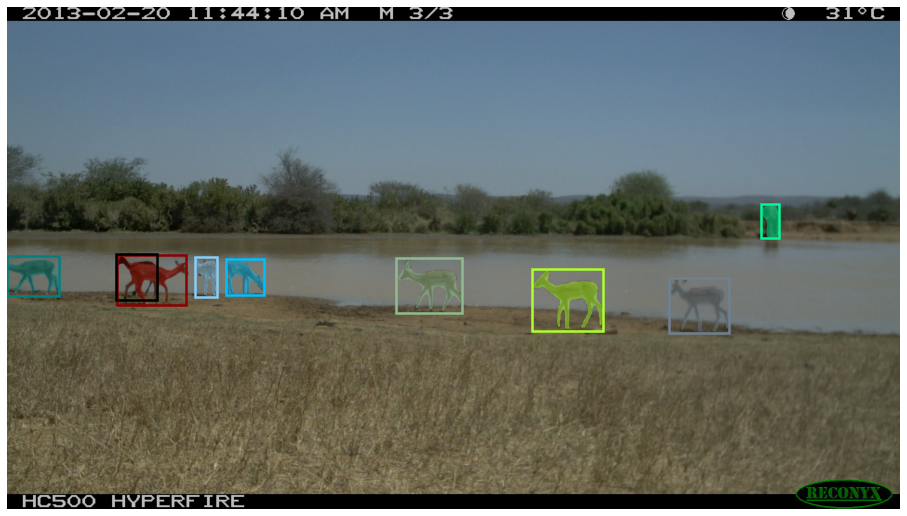

In [7]:
# Run DeepMAC and show result

image_path = '/kaggle/input/iwildcam2021-fgvc8/train/905e980e-21bc-11ea-a13a-137349068a90.jpg'
image_id = os.path.basename(image_path).rstrip('.jpg')

if image_id not in detection_map:
    print(f'Image {image_path} is missing detection data.')
elif len(detection_map[image_id]) == 0:
    print(f'There are no detected objects in the image {image_path}.')
else:
    detections = detection_map[image_id]
    image = read_image(image_path)
    bboxes = np.array([det['bbox'] for det in detections])
    bboxes = convert_boxes(bboxes)
    masks = prediction_function(tf.convert_to_tensor(image),
                                tf.convert_to_tensor(bboxes, dtype=tf.float32))
    plot_image_annotations(image, bboxes, masks.numpy(), darken_image=0.75)

We can see that masks have been created for the animals in the Bboxes.

There are 9 inastane masks.


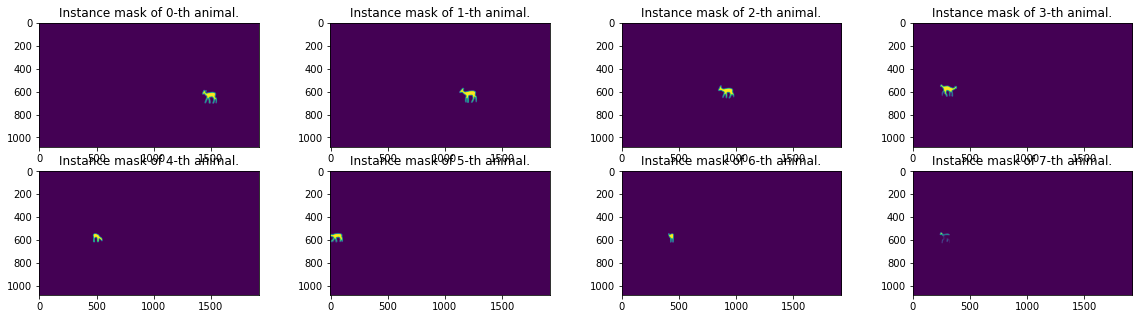

In [8]:
print(f"There are {len(masks)} inastane masks.")

fig, axs = plt.subplots(2, 4, figsize=(20,5))
for i in range(8):
    col_num = i % 4
    row_num = i // 4
    axs[row_num, col_num].imshow(masks[i])
    axs[row_num, col_num].set_title(f'Instance mask of {i}-th animal.')

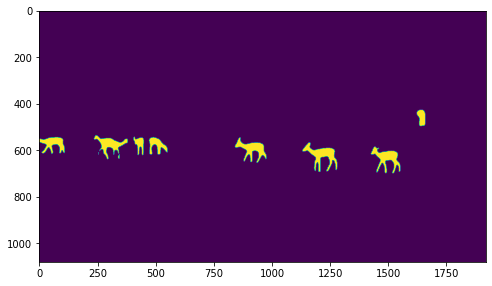

In [9]:
# Show result as one image

def overlap_masks(masks):
    """Overlap masks and return one mask"""
    
    masks = masks.numpy()
    mask_overlapped = np.zeros_like(masks[0])

    for mask in masks:
        mask_overlapped = np.logical_or((mask > 0.5).astype(np.float32), mask_overlapped)
    
    return mask_overlapped
    
plt.figure(figsize=(8,8))
plt.imshow(overlap_masks(masks))

In [10]:
#Save memory

del detection_map
gc.collect()

4213

--------------

<a id="3"></a>
# Examle2 Global Wheat Detection

We'll see how it works in another example. [Global Wheat Detection](https://www.kaggle.com/c/global-wheat-detection) was competiton to detect wheat spikes with computer vision. To do so, it may be able to automatically detect the degree of growth and abnormalities. 

Since we are given the Bbox in train.csv, we will use it to create the masks in the same way as in Example1.

## Load metadata information and process

In [11]:
# Load bbox data

global_wheat_detection_train = pd.read_csv("../input/global-wheat-detection/train.csv")

In [12]:
# Function to convert data format of bbox

def convert_deepmac_format_from_gwd_train(df):
    """Convert train csv of global_wheat_detection to the format same as Example1"""
    image_ids = []
    bboxs = []
    result_df = defaultdict(list)
    
    for i in range(len(df)):
        image_id = df.iloc[i]["image_id"]
        bbox = df.iloc[i]["bbox"]
        
        # Converts string to list of 4 floats and normalizes them by 1024.
        bbox = [float(item.strip())/1024 for item in bbox[1:-1].split(",")]
        
        image_ids.append(image_id)
        bboxs.append(bbox)
    
    d = defaultdict(list)
    for image_id, bbox in zip(image_ids, bboxs):
        result_df[image_id].append({"bbox": bbox})
    
    return result_df

In [13]:
# Convert data format of bbox

global_wheat_detection_train = convert_deepmac_format_from_gwd_train(global_wheat_detection_train)
bboxes = np.array([det['bbox'] for det in detections])

## Running inference

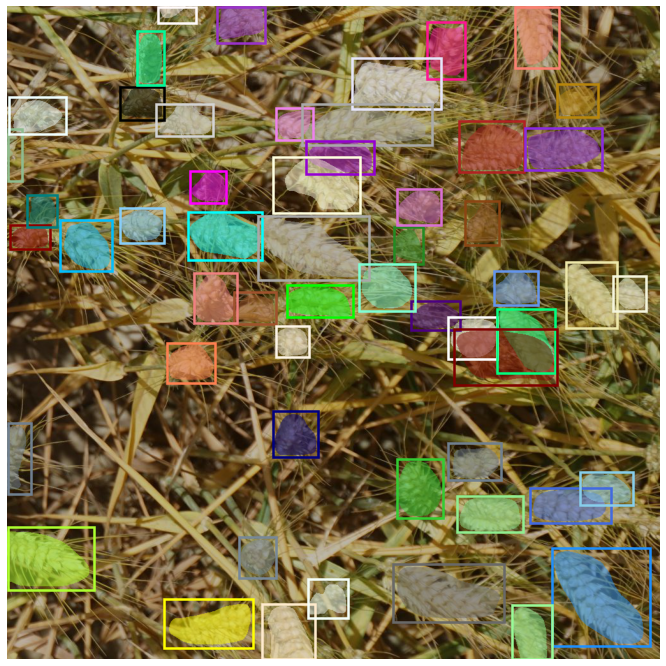

In [14]:
# Run DeepMAC and show result

image_path = '../input/global-wheat-detection/train/00333207f.jpg'
image_id = os.path.basename(image_path).rstrip('.jpg')

if image_id not in global_wheat_detection_train:
    print(f'Image {image_path} is missing detection data.')
elif len(global_wheat_detection_train[image_id]) == 0:
    print(f'There are no detected objects in the image {image_path}.')
else:
    detections = global_wheat_detection_train[image_id]
    image = read_image(image_path)
    bboxes = np.array([det['bbox'] for det in detections])
    bboxes = convert_boxes(bboxes)
    masks = prediction_function(tf.convert_to_tensor(image),
                                tf.convert_to_tensor(bboxes, dtype=tf.float32))
    plot_image_annotations(image, bboxes, masks.numpy(), darken_image=0.75)

In this example, too, we can see that we have created a mask for wheat spikes.

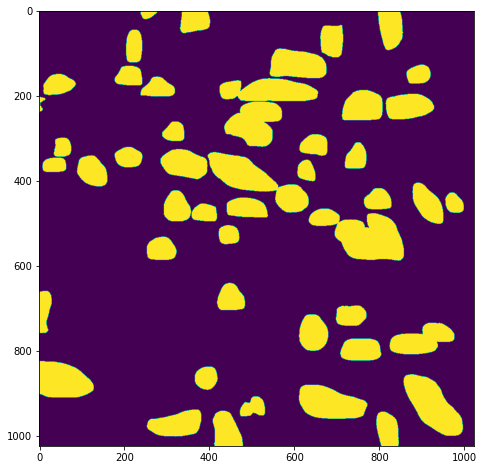

In [15]:
# Show result as one image
    
plt.figure(figsize=(8,8))
plt.imshow(overlap_masks(masks))

In [16]:
#Save memory

del global_wheat_detection_train
gc.collect()

9816

------------

<a id="4"></a>
# Examle3 HuBMAP - Hacking the Kidney

Goal of this competition is development of a segmentation algorithm to identify the "Glomerulus" in the kidney. We are given train image, segmentation mask and annotation data.

However, some of the masks and annotation data are incomplete, and methods to correct them are being studied.

If we can use DeepMAC to create masks, it may be much easier than doing precise hand labeling, although we will need to create Bboxes. Also, the annotations can be dropped into the program, making it more reproducible.

Currently, solutions are image segmentation, but we may be able to choose detection as our strategy if DeepMAC generates good mask.

## Load metadata information and process

[image_id].json includes, annotation data (not bbox), I'll load this. I also load corresponding image.

<div class="alert alert-block alert-warning">I will implement some utility functions in following cells, but what I want to do is to create image and Bbox of a good size to be input to DeepMAC.</div>

In [17]:
# Select sample image id

image_id = "aaa6a05cc"

In [18]:
# Load annotation data

with open(f"../input/hubmap-kidney-segmentation/train/{image_id}.json") as f:
    structure_aaa6a05cc = json.load(f)

In [19]:
# Load image
image_aaa6a05cc = tiff.imread(f"../input/hubmap-kidney-segmentation/train/{image_id}.tiff")
print( "Shape: ", image_aaa6a05cc.shape)

Shape:  (18484, 13013, 3)


I'll convert annotation data to bbox, because it is not bbox, but set of coordinates (If you want to know detail, please see [HuBMAP Let's Visualize and Understand Dataset](https://www.kaggle.com/nayuts/hubmap-let-s-visualize-and-understand-dataset#With-Annotation-json-file)). 

I will also create a function to display the bbox and the image together to make sure that the conversion is successful. In addition, since original image is so huge, I will also create a function to crop the image and generate the corresponding bbox. 

In [20]:
#Function to convert annotation data to bbox

def convert_bbox_from_coordinates(coordinates, image_shape):
    """convert coordinates to bbox"""
    x_max = max([coor[0] for coor in coordinates])
    x_min = min([coor[0] for coor in coordinates])
    y_max = max([coor[1] for coor in coordinates])
    y_min = min([coor[1] for coor in coordinates])
    
    h, w, _ = image_shape
    
    return [x_min/w, y_min/h, (x_max - x_min)/w, (y_max - y_min)/h]

def create_bbox_from_coordinates(structure, image_id, image):
    """convert coordinates to bbox of glomerulus"""
    result_dict = {}
    result = []
    
    image_shape = image.shape
    
    for glomerulus in structure:
        for coordinates in glomerulus["geometry"]["coordinates"]:
            result.append(convert_bbox_from_coordinates(coordinates, image_shape))
            
    result_dict[image_id] = result
    
    return result_dict

In [21]:
#Function to display the bbox and the image together

def draw_bboxs(im, bboxes):
    """
    detections_list: list of set includes bbox.
    im: image read by Pillow.
    """
    h_image, w_image,  _ = im.shape
    
    im = Image.fromarray(im)
    draw = ImageDraw.Draw(im)
    
    for bbox in bboxes:
        x1, y1,w_box, h_box = bbox
        ymin, xmin, ymax, xmax = y1, x1, y1 + h_box, x1 + w_box
        ymin, xmin, ymax, xmax = ymin*h_image, xmin*w_image, ymax*h_image, xmax*w_image
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
        
        draw.line([(left, top), (left, bottom), (right, bottom),
               (right, top), (left, top)], width=10, fill='Red')
    return im

In [22]:
#Function to crop the image and generate the corresponding bbox

def has_intersect(a, b):
    """Detect intersect of two rectangles
    
    Rectangle is represented as [x_min, x_max, y_min. y_max]
    """
    #return max(a[0], b[0]) <= min(a[1], b[1]) and max(a[2], b[2]) <= min(a[3], b[3])
    return (a[0] < b[1] and a[1] > b[0] and a[3] > b[2] and a[2] < b[3])

def crop_image_and_bboxes(image, bboxes, range_axis0, range_axis1):
    
    result_bboxes = []
    range_axis1_min = range_axis1[0]
    range_axis1_max = range_axis1[1]
    range_axis0_min = range_axis0[0]
    range_axis0_max = range_axis0[1]
    
    w_image = range_axis1_max - range_axis1_min
    h_image = range_axis0_max - range_axis0_min
    
    h_org, w_org, _ = image.shape
    
    for bbox in bboxes:
        x1, y1,w_box, h_box = bbox
        ymin, xmin, ymax, xmax = y1, x1, y1 + h_box, x1 + w_box
        ymin, xmin, ymax, xmax = ymin*h_org, xmin*w_org, ymax*h_org, xmax*w_org
        
        if not has_intersect([xmin, xmax, ymin, ymax],
                             [range_axis1_min, range_axis1_max, range_axis0_min, range_axis0_max]):
            continue
        else:
            new_rectangle = [max(xmin, range_axis1_min) - range_axis1_min,
                             min(xmax, range_axis1_max) - range_axis1_min,
                             max(ymin, range_axis0_min) - range_axis0_min, 
                             min(ymax, range_axis0_max) - range_axis0_min]
        
            new_bbox = [new_rectangle[0]/w_image,
                        new_rectangle[2]/h_image,
                        (new_rectangle[1]- new_rectangle[0])/w_image, 
                        (new_rectangle[3]- new_rectangle[2])/h_image]
            result_bboxes.append(new_bbox)
    
    return image[range_axis0_min:range_axis0_max, range_axis1_min:range_axis1_max, :], result_bboxes

Create bboxes and crop image and boxes.

In [23]:
#Process inage and Bbox

bboxes = create_bbox_from_coordinates(structure_aaa6a05cc, image_id, image_aaa6a05cc)
image_croped, bboxes_croped = crop_image_and_bboxes(image_aaa6a05cc, bboxes[image_id], [6200, 7200], [6200, 7200])

Check the results. It looks like we have successfully created bboxes.

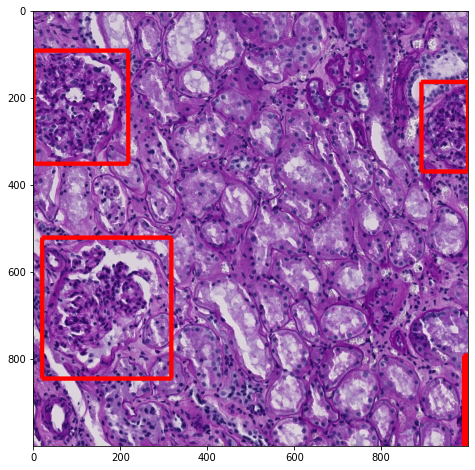

In [24]:
# Show cropping and Bbox

plt.figure(figsize=(8,8))
image_croped_with_bbox = draw_bboxs(image_croped, bboxes_croped)
plt.imshow(image_croped_with_bbox)

## Running inference

We got croped image and bboxes, we can inference masks.

<AxesSubplot:>

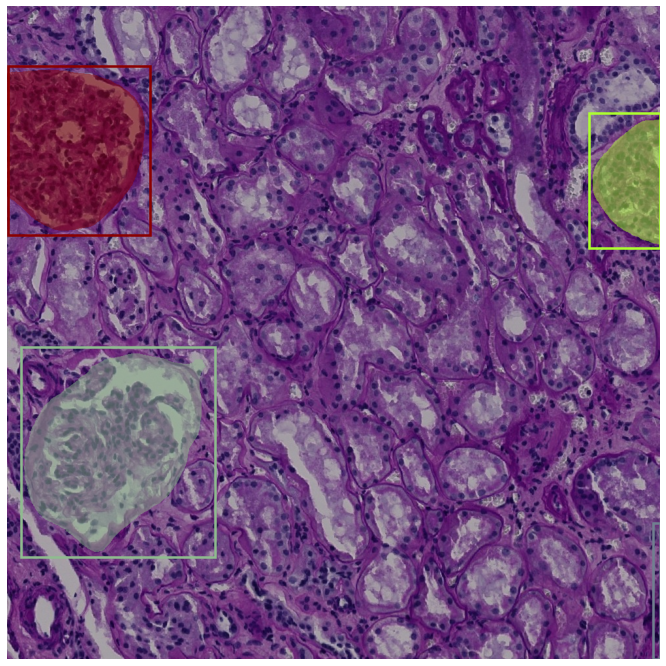

In [25]:
# Run DeepMAC and show result

bboxes_croped = np.array(bboxes_croped)
bboxes_croped = convert_boxes(bboxes_croped)
masks = prediction_function(tf.convert_to_tensor(image_croped),
                            tf.convert_to_tensor(bboxes_croped, dtype=tf.float32))
plot_image_annotations(image_croped, bboxes_croped, masks.numpy(), darken_image=0.75)

As we can see, we were able to create the masks better than we had imagined!

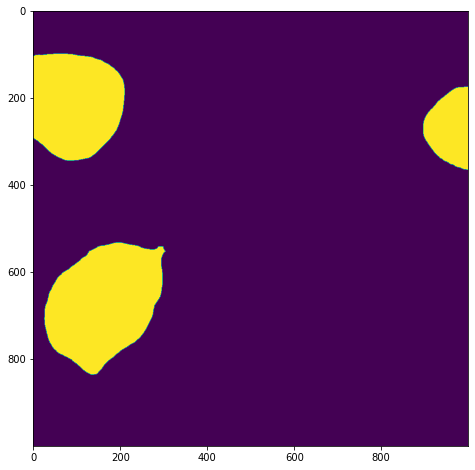

In [26]:
# Show result as one image

mask_overlapped = overlap_masks(masks)
    
plt.figure(figsize=(8,8))
plt.imshow(mask_overlapped)

Make sure that it matches the test data.　Load encoded mask from train.csv and decode it.

In [27]:
#Load given mask as dataset.

# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

hubmap_train = pd.read_csv("../input/hubmap-kidney-segmentation/train.csv")
mask_given = rle2mask(hubmap_train[hubmap_train["id"]==image_id]["encoding"].iloc[-1],
                      (image_aaa6a05cc.shape[1], image_aaa6a05cc.shape[0]))

Here is a side-by-side comparison.

Text(0.5, 1.0, 'Given mask')

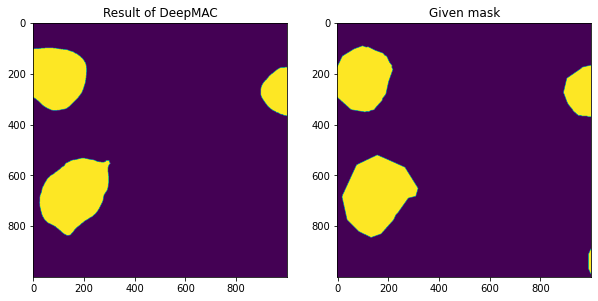

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(mask_overlapped)
axs[0].set_title('Result of DeepMAC')
axs[1].imshow(mask_given[6200:7200, 6200:7200])
axs[1].set_title('Given mask')

Check how well they match.

In [29]:
print("Percentage of match: ", np.sum(mask_overlapped == mask_given[6200:7200, 6200:7200]) / np.sum(np.ones_like(mask_overlapped)) * 100, "%")

Percentage of match:  98.2717 %


Check in other areas.

Percentage of match of [1000:5000, 1200:6200] of aaa6a05cc:  99.87205 %


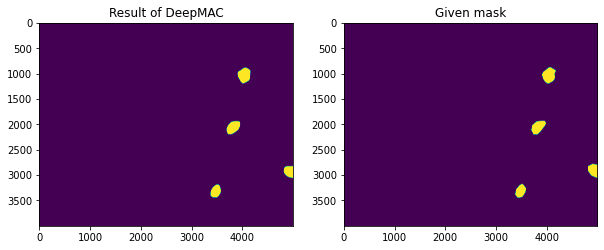

In [30]:
image_croped, bboxes_croped = crop_image_and_bboxes(image_aaa6a05cc, bboxes[image_id], 
                                                    [1000, 5000], [1200, 6200])
bboxes_croped = np.array(bboxes_croped)
bboxes_croped = convert_boxes(bboxes_croped)
masks = prediction_function(tf.convert_to_tensor(image_croped),
                            tf.convert_to_tensor(bboxes_croped, dtype=tf.float32))
mask_overlapped = overlap_masks(masks)

# Show result
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(mask_overlapped)
axs[0].set_title('Result of DeepMAC')
axs[1].imshow(mask_given[1000:5000, 1200:6200])
axs[1].set_title('Given mask')

# Percentage of match
print(f"Percentage of match of [1000:5000, 1200:6200] of {image_id}: ",
      np.sum(mask_overlapped == mask_given[1000:5000, 1200:6200]) /
      np.sum(np.ones_like(mask_overlapped)) * 100, "%")

Percentage of match of [1000:3000, 7200:8600] of aaa6a05cc:  99.49089285714285 %


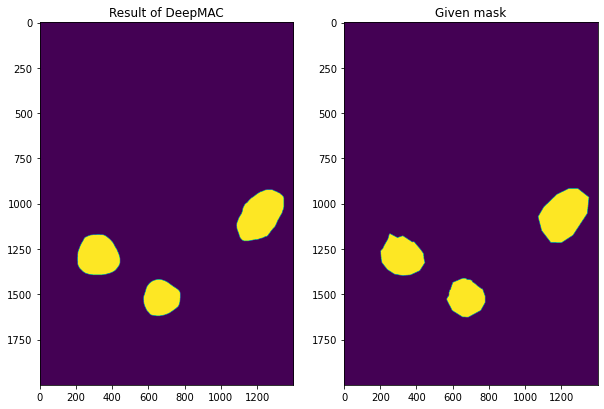

In [31]:
image_croped, bboxes_croped = crop_image_and_bboxes(image_aaa6a05cc, bboxes[image_id], 
                                                    [1000, 3000], [7200, 8600])
bboxes_croped = np.array(bboxes_croped)
bboxes_croped = convert_boxes(bboxes_croped)
masks = prediction_function(tf.convert_to_tensor(image_croped),
                            tf.convert_to_tensor(bboxes_croped, dtype=tf.float32))
mask_overlapped = overlap_masks(masks)

# Show result
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(mask_overlapped)
axs[0].set_title('Result of DeepMAC')
axs[1].imshow(mask_given[1000:3000, 7200:8600])
axs[1].set_title('Given mask')

# Percentage of match
print(f"Percentage of match of [1000:3000, 7200:8600] of {image_id}: ",
      np.sum(mask_overlapped == mask_given[1000:3000, 7200:8600]) /
      np.sum(np.ones_like(mask_overlapped)) * 100, "%")

Percentage of match of [5000:10000, 5000:10000] of aaa6a05cc:  98.971268 %


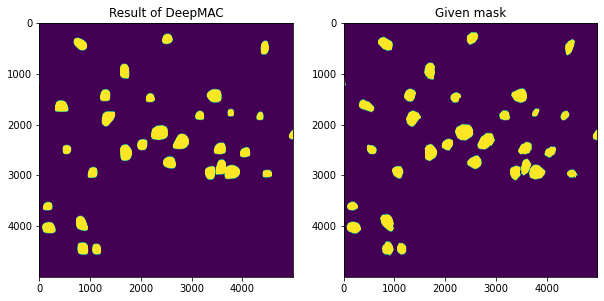

In [32]:
image_croped, bboxes_croped = crop_image_and_bboxes(image_aaa6a05cc, bboxes[image_id], 
                                                    [5000, 10000], [5000, 10000])
bboxes_croped = np.array(bboxes_croped)
bboxes_croped = convert_boxes(bboxes_croped)
masks = prediction_function(tf.convert_to_tensor(image_croped),
                            tf.convert_to_tensor(bboxes_croped, dtype=tf.float32))
mask_overlapped = overlap_masks(masks)

# Show result
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(mask_overlapped)
axs[0].set_title('Result of DeepMAC')
axs[1].imshow(mask_given[5000:10000, 5000:10000])
axs[1].set_title('Given mask')

print(f"Percentage of match of [5000:10000, 5000:10000] of {image_id}: ",
      np.sum(mask_overlapped == mask_given[5000:10000, 5000:10000]) /
      np.sum(np.ones_like(mask_overlapped)) * 100, "%")

In [33]:
del image_aaa6a05cc, hubmap_train, 
gc.collect()

36005

---------------------

<a id="5"></a>
# Application1 Create instance mask of iWildcam 2021 for MOTS

It is still challenging to track objects when multiple objects are involved. Multi-object tracking and segmentation (MOTS) was first introduced in [MOTS: Multi-Object Tracking and Segmentation](https://arxiv.org/abs/1902.03604) at 2019. Until then, the mainstream tracking method used banding boxes.  However, when the boxes overlap each other, the accuracy of the tracking is reduced. The segmentation method has the potential to solve this problem and is being studied.

Dataset of [iWildcam 2021 - FGVC8](https://www.kaggle.com/c/iwildcam2021-fgvc8/data) already provides instance masks as additional png files. But annotation file follows COCO format, so we also see how to create masks processed one by [RLE](https://en.wikipedia.org/wiki/Run-length_encoding) or extract contours COCO format usually provides.

### Load data

In [34]:
BOX_ANNOTATION_FILE = '/kaggle/input/iwildcam2021-fgvc8/metadata/iwildcam2021_megadetector_results.json'
detection_map = create_detection_map(read_json(BOX_ANNOTATION_FILE))
    
image_path = '/kaggle/input/iwildcam2021-fgvc8/train/90605482-21bc-11ea-a13a-137349068a90.jpg'
image_id = os.path.basename(image_path).rstrip('.jpg')
im = Image.open(image_path)

### Show target image with bbox

In this image (image id: 90605482-21bc-11ea-a13a-137349068a90), some bounding box overlaps  each other. Therefore, to achieve accurate tracking, we may choose to create segmentation as strategy.

Text(0.5, 1.0, '90605482-21bc-11ea-a13a-137349068a90 image with bbox')

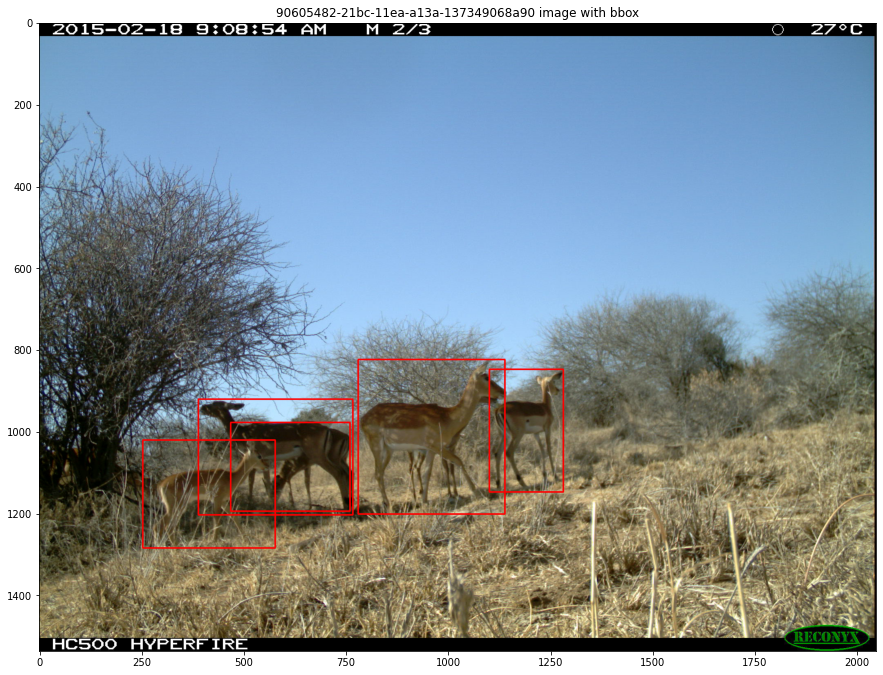

In [35]:
# Show target image and bboxes

def draw_bboxs_app1(detections_list, im):
    """
    detections_list: list of set includes bbox.
    im: image read by Pillow.
    
    #Refered: https://www.kaggle.com/qinhui1999/how-to-use-bbox-for-iwildcam-2020 
    """
    
    for detection in detections_list:
        x1, y1,w_box, h_box = detection["bbox"]
        ymin,xmin,ymax, xmax=y1, x1, y1 + h_box, x1 + w_box
        draw = ImageDraw.Draw(im)
        
        imageWidth=im.size[0]
        imageHeight= im.size[1]
        (left, right, top, bottom) = (xmin * imageWidth, xmax * imageWidth,
                                      ymin * imageHeight, ymax * imageHeight)
        
        draw.line([(left, top), (left, bottom), (right, bottom),
               (right, top), (left, top)], width=4, fill='Red')
        
draw_bboxs_app1(detection_map[image_id], im)
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.title(f"{image_id} image with bbox")

### Create instance masks

With DeepMAC, we will create instance masks.

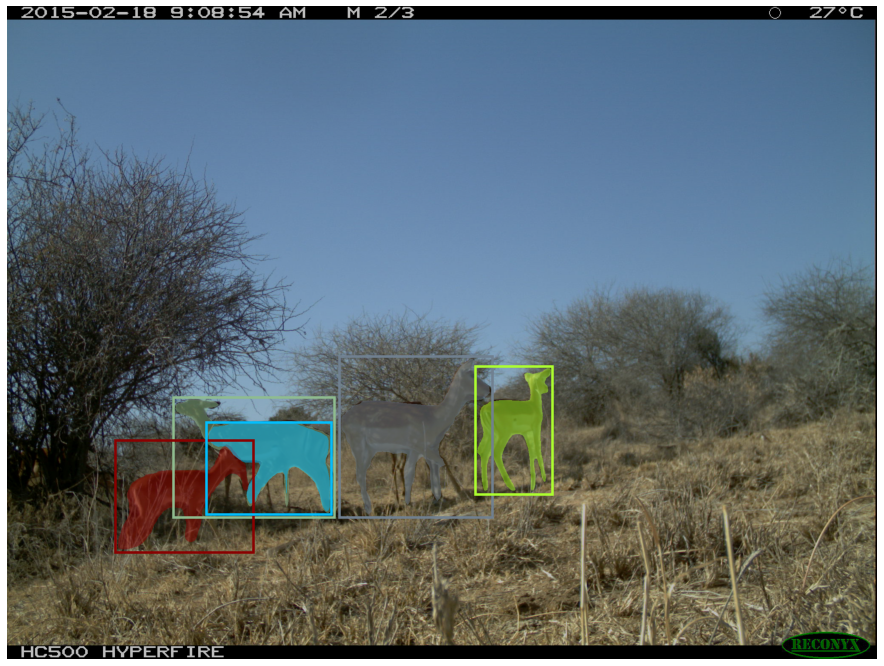

In [36]:
# Run DeepMAC and show result

if image_id not in detection_map:
    print(f'Image {image_path} is missing detection data.')
elif len(detection_map[image_id]) == 0:
    print(f'There are no detected objects in the image {image_path}.')
else:
    detections = detection_map[image_id]
    image = read_image(image_path)
    bboxes = np.array([det['bbox'] for det in detections])
    bboxes = convert_boxes(bboxes)
    masks = prediction_function(tf.convert_to_tensor(image),
                                tf.convert_to_tensor(bboxes, dtype=tf.float32))
    plot_image_annotations(image, bboxes, masks.numpy(), darken_image=0.75)

There are 5 inastane masks.


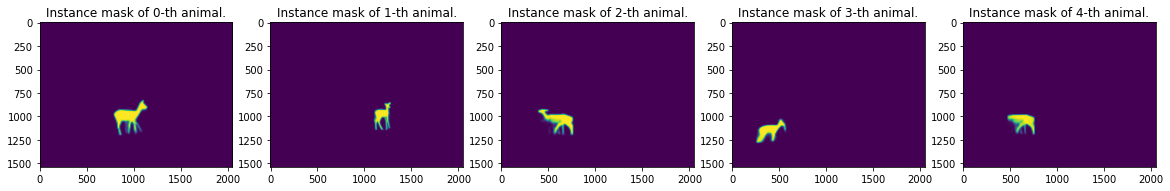

In [37]:
# Show result

print(f"There are {len(masks)} inastane masks.")

fig, axs = plt.subplots(1, 5, figsize=(20,5))
for i in range(5):
    axs[i].imshow(masks[i])
    axs[i].set_title(f'Instance mask of {i}-th animal.')

Now, I'll try to convert the masks to following two format COCO format provides.

1. [Contours of mask](#5-1)
2. [Encoded with RLE](#5-2)

I won't append the encoded mask to given annotation files(iwildcam2021_train_annotations.json and iwildcam2021_test_annotations.json) because it was a little difficult.

Incidentally, the assumption of segmentation preservation according to the COCO format is as follows.

In [38]:
# Contours version
"""
"annotations": [
    {
        "segmentation": [[100, 300, ..., 500.4, 200.01]],
        "image_id": 90605482-21bc-11ea-a13a-137349068a90,
        "category_id": 9,
        "id": 15
    },
    ...
]
"""

# RLE encorded version
"""
"annotations": [
    {
        "segmentation": {
            "counts": [179,27,392,41,…,55,20],
            "size": [426,640]
        },
        "image_id": 90605482-21bc-11ea-a13a-137349068a90,
        "category_id": 9,
        "id": 15
    }
]
"""

'\n"annotations": [\n    {\n        "segmentation": {\n            "counts": [179,27,392,41,…,55,20],\n            "size": [426,640]\n        },\n        "image_id": 90605482-21bc-11ea-a13a-137349068a90,\n        "category_id": 9,\n        "id": 15\n    }\n]\n'

<a id="5-1"></a>
### 1. Create contours of mask

First, we create contours of mask. by find_contours method of skimage, we can easily try this.

In [39]:
# Extract contours from instance masks

contours_results = [measure.find_contours(mask.numpy(), 0.5) for mask in masks]

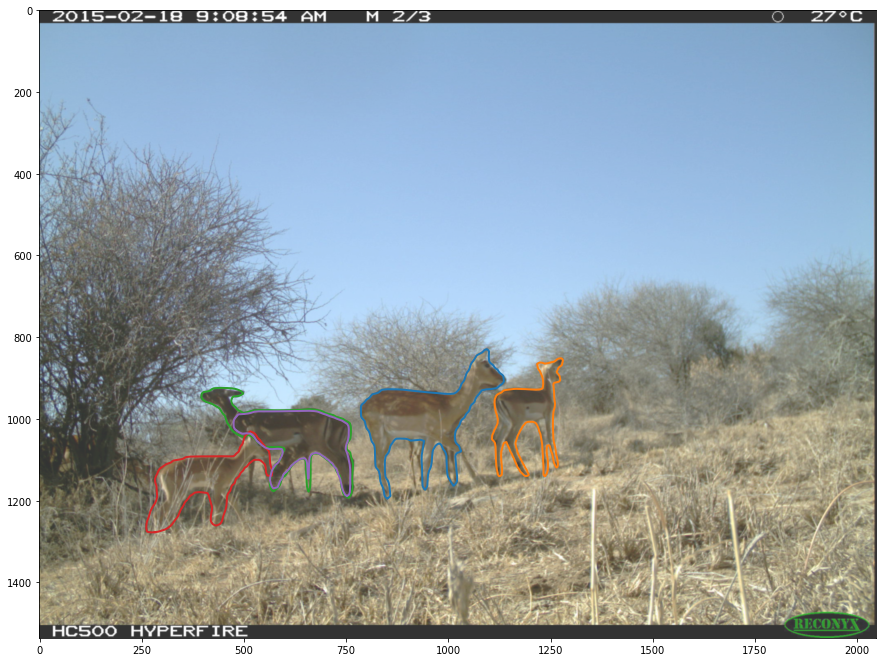

In [40]:
# Show contours with image
# https://scikit-image.org/docs/0.5/auto_examples/plot_contours.html

im = Image.open(image_path)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(im, cmap=plt.cm.cividis, interpolation='gaussian',alpha=0.8)
for contours in contours_results:
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

In [41]:
# Convert the result to save COCO dataset
# https://github.com/cocodataset/cocoapi/issues/131

segmentations = []
for contour in contours:
    contour = np.flip(contour, axis=1)
    segmentations.append(contour.ravel().tolist())

In [42]:
segmentations[0]

[752.0,
 1188.0778838511324,
 751.7357356467387,
 1188.0,
 751.0,
 1187.7731062204837,
 750.0,
 1187.2605988665268,
 749.5427313216861,
 1187.0,
 749.0,
 1186.6659083021632,
 748.0427708593597,
 1186.0,
 748.0,
 1185.9460802511462,
 747.2753987941845,
 1185.0,
 747.0,
 1184.5128331968435,
 746.71150230616,
 1184.0,
 746.1530682007891,
 1183.0,
 746.0,
 1182.7241409775784,
 745.6001832552191,
 1182.0,
 745.0526893055554,
 1181.0,
 745.0,
 1180.903246478695,
 744.5104629853897,
 1180.0,
 744.0,
 1179.0496532947632,
 743.9734600259994,
 1179.0,
 743.5444841560776,
 1178.0,
 743.1270493999327,
 1177.0,
 743.0,
 1176.7083899654688,
 742.6953229108669,
 1176.0,
 742.2604609193269,
 1175.0,
 742.0,
 1174.4071939450807,
 741.8464926228447,
 1174.0,
 741.4869593536456,
 1173.0,
 741.1503319367151,
 1172.0,
 741.0,
 1171.5242962713617,
 740.8388728500934,
 1171.0,
 740.5450748594357,
 1170.0,
 740.2661393372741,
 1169.0,
 740.0009668190469,
 1168.0,
 740.0,
 1167.9962614324174,
 739.748581054676

<a id="5-2"></a>
### 2. Create RLE encorded mask

In [43]:
# Create instance mask

overlaped_mask = overlap_masks(masks)

In [44]:
#https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
#with bug fix
def rle_encode_less_memory(img):
    #watch out for the bug
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

rle_encode_less_memory(overlaped_mask)

'402161 4 403688 19 405219 26 406752 30 408286 32 409820 34 411353 37 412885 41 414418 45 415950 49 417484 51 419017 54 420551 56 422085 58 423619 60 425154 61 426688 63 428222 65 429757 66 431291 68 432826 69 434360 71 435834 12 435894 72 437367 18 437428 74 438900 23 438961 77 440435 29 440495 79 441969 45 442026 84 443503 143 445036 145 446570 147 448104 149 449638 151 451173 151 452707 153 454242 154 455778 153 457313 154 458848 155 460384 154 461919 155 463454 156 464990 155 466525 156 468060 157 469595 158 471130 158 472666 158 474201 158 475737 158 477272 158 478808 158 480343 158 481879 158 483415 157 484950 157 486486 157 488022 156 489557 156 491093 155 492629 154 494164 154 495699 154 497235 153 498770 153 500305 153 501840 153 503375 153 504911 151 506447 150 507983 148 509519 146 511054 146 512590 145 514126 143 515662 142 517198 141 518734 140 520270 138 521805 138 523341 136 524877 133 526413 131 527949 128 529485 125 531021 123 532556 122 534092 120 535628 119 537164 11

<a id="6"></a>
# Application2 Create instance mask of HuBMAP in a way that can be automated as much as possible.

At the HuBMAP competition, there was unannotated data in train data that has been actively discussed. We don't know how private dataset is annotated, so we don't know if that makes sense, but from [this discussion](https://www.kaggle.com/c/hubmap-kidney-segmentation/discussion/227616#1250442), adding handwritten annotations for training is allowed.  I haven't gotten around to it yet, if we can automate the creation of the bbox for glomerular with detection model, we can automate the creation of the mask, we can the result of process as pseudo-label. Let's apply DeepMAC to this problem.

### Step1 Load image and find unannotated one

In [45]:
# Load image
image_id = "aaa6a05cc"
image_aaa6a05cc = tiff.imread(f"../input/hubmap-kidney-segmentation/train/{image_id}.tiff")

In this case, we assume that the glomerulus in the image below was not annotated. In the actual data, this glomerulus has been annotated.

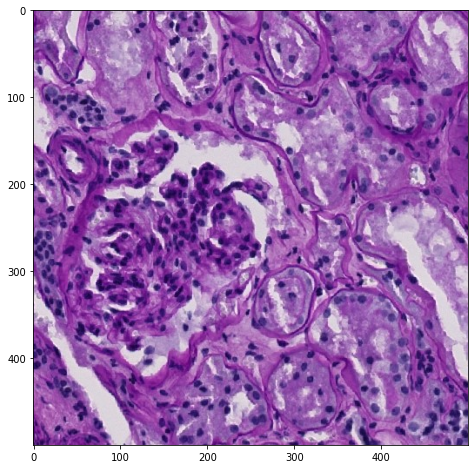

In [46]:
# Crop the found unannotated parts.
plt.figure(figsize=(8,8))
plt.imshow(image_aaa6a05cc[6600:7100, 6200:6700, :])

### Step2 Crop image and create bbox

In this article, I have created create_bbox() function as simple bbox creation tool. In practice, you can use anything you like.

In [47]:
# Crop image and create Bbox

unannotated_image = image_aaa6a05cc[6600:7100, 6200:6700, :]

def create_bbox(xmin, ymin, w, h, image_shape):
    """return bbox
    
    xmin       : x-coordinate (axis1-coordinate) of the left edge of the bbox.
    ymin       : y-coordinate (axis0-coordinate) of the top edge of the bbox.
    w          : with of cropped image.  
    h          : height of cropped image.  
    image_shape: shape of cropped image.
    
    """
    return [xmin/image_shape[0], ymin/image_shape[1],
            w/image_shape[0], h/image_shape[1]]

annotate_bbox = create_bbox(30, 100, 270, 330, unannotated_image.shape)

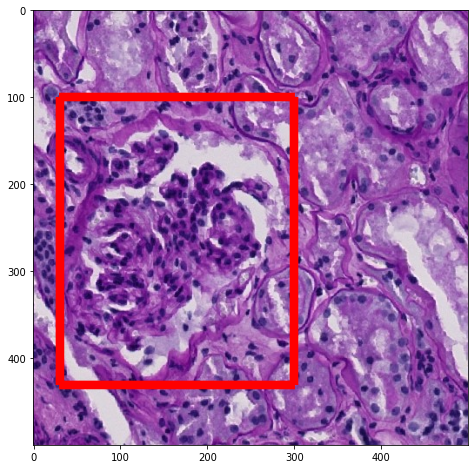

In [48]:
# Show our bbox and unannotated image

plt.figure(figsize=(8,8))
plt.imshow(draw_bboxs(unannotated_image, [annotate_bbox]))

### Step3 Create mask

Create mask with DeepMAC.

In [49]:
# Create instance mask

def create_mask(image, bboxes):
    """Create mask with DeepMAC from given image and bbox
    
    image : Cropped image.
    bboxes: List of bbox.
    
    """
    
    bboxes = convert_boxes(np.array(bboxes))
    masks = prediction_function(tf.convert_to_tensor(image),
                                tf.convert_to_tensor(bboxes, dtype=tf.float32))
    mask_overlapped = overlap_masks(masks)
    return mask_overlapped

mask_overlapped = create_mask(unannotated_image, [annotate_bbox])

Check result.

Text(0.5, 1.0, 'New mask on image')

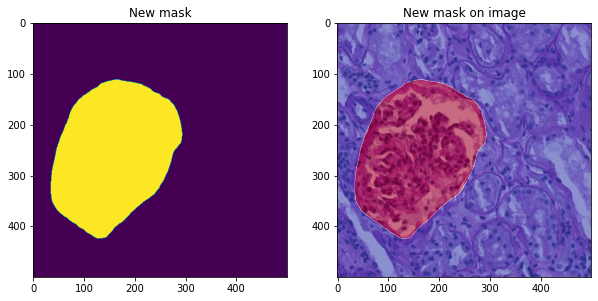

In [50]:
# Show result
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(mask_overlapped)
axs[0].set_title('New mask')
axs[1].imshow(unannotated_image)
axs[1].imshow(mask_overlapped, cmap='coolwarm', alpha=0.5)
axs[1].set_title('New mask on image')

### Step4 intefrate mask with existing mask

Load mask and replace the corresponding part with the new mask.

In [51]:
# Integrate the mask with the existing one
hubmap_train = pd.read_csv("../input/hubmap-kidney-segmentation/train.csv")
mask_given = rle2mask(hubmap_train[hubmap_train["id"]==image_id]["encoding"].iloc[-1],
                      (image_aaa6a05cc.shape[1], image_aaa6a05cc.shape[0]))
mask_given[6600:7100, 6200:6700] = mask_overlapped

It seems that the result of mask is largely effected by bbox. If we want to automate using the detection model, it is likely that the detection model will need to have reasonable performance.

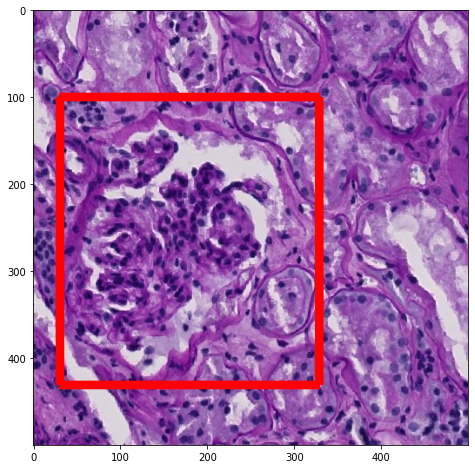

In [52]:
annotate_bbox = create_bbox(30, 100, 300, 330, unannotated_image.shape)

# Show our bbox and unannotated image

plt.figure(figsize=(8,8))
plt.imshow(draw_bboxs(unannotated_image, [annotate_bbox]))

Text(0.5, 1.0, 'New mask on image')

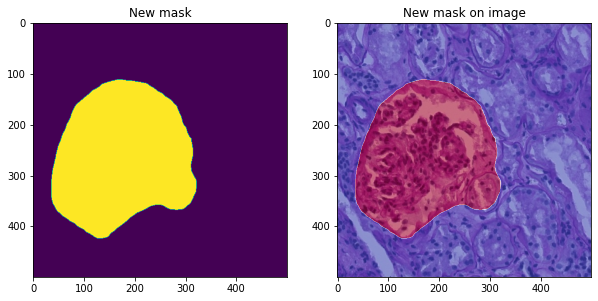

In [53]:
mask_overlapped = create_mask(unannotated_image, [annotate_bbox])

# Show result
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(mask_overlapped)
axs[0].set_title('New mask')
axs[1].imshow(unannotated_image)
axs[1].imshow(mask_overlapped, cmap='coolwarm', alpha=0.5)
axs[1].set_title('New mask on image')